In [1]:
import numpy as np 
import os
import pandas as pd
import random
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

In [2]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Flatten, MaxPool2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
random.seed(3)
tf.random.set_seed(3)

In [4]:
train_dir = './dogs-vs-cats/train'
test_dir = './dogs-vs-cats/test'

In [5]:
filenames = os.listdir(train_dir)
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

In [6]:
df = pd.DataFrame({'filename':filenames,
                    'category': categories})

In [7]:
df[:10]

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
5,cat.10000.jpg,0
6,cat.10001.jpg,0
7,cat.10002.jpg,0
8,cat.10003.jpg,0
9,cat.10004.jpg,0


In [8]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [9]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


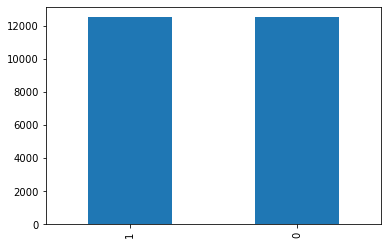

In [10]:
df['category'].value_counts().plot.bar()

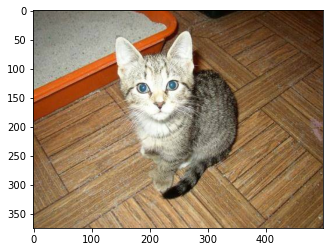

In [11]:
sample = random.choice(filenames)
image = mpimg.imread(train_dir + '/'+ sample)
plt.imshow(image)

In [12]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [13]:
train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 3)
train_df = train_df.reset_index(drop =True)
val_df = val_df.reset_index(drop =True)

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range= 0.1, zoom_range= 0.3, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
img_width = 128
img_height = 128
batch_size = 16

In [16]:
train_generator = train_datagen.flow_from_dataframe(train_df, 
                    train_dir, 
                    x_col='filename',
                    y_col='category',
                    target_size=(img_width, img_height),
                    class_mode='categorical',
                    batch_size= batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [17]:
val_generator = val_datagen.flow_from_dataframe(val_df, 
                    train_dir, 
                    x_col='filename',
                    y_col='category',
                    target_size=(img_width, img_height),
                    class_mode='categorical',
                    batch_size= batch_size)

Found 5000 validated image filenames belonging to 2 classes.


## Build VGG16 Model

In [18]:
def plot_data(train_data, val_data, title):
    plt.plot(train_data)
    plt.plot(val_data)
    plt.legend(['Training_data','validation_data'])
    plt.title("Model " + str(title))
    plt.xlabel('Epoch')
    plt.ylabel(title)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [56]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),kernel_initializer='he_uniform', input_shape = (img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters=128, kernel_size=(5,5), kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

In [57]:
optimizer = RMSprop(lr = 0.001)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [58]:
#val_loss
early_stop = EarlyStopping(patience=10)
#val_accuracy
learning_rate_reduction =ReduceLROnPlateau(monitor='val_accuracy', patience=2,
                                            verbose = True , factor = 0.5, min_lr=0.00001)
callbacks = [early_stop, learning_rate_reduction]

In [59]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 59, 59, 64)        51264     
_________________________________________________________________
batch_normalization_25 (Batc (None, 59, 59, 64)        256       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 29, 29, 64)       

In [60]:
history = model.fit(train_generator, steps_per_epoch = len(train_generator), epochs = 50, validation_data = val_generator, validation_steps = len(val_generator), callbacks=callbacks)

Epoch 1/50
1250/1250 [==============================] - 81s 65ms/step - loss: 1.0455 - accuracy: 0.5457 - val_loss: 0.6523 - val_accuracy: 0.6280 - lr: 0.0010
Epoch 2/50
1250/1250 [==============================] - 79s 64ms/step - loss: 0.7088 - accuracy: 0.6068 - val_loss: 0.6733 - val_accuracy: 0.6552 - lr: 0.0010
Epoch 3/50
1250/1250 [==============================] - 79s 63ms/step - loss: 0.6884 - accuracy: 0.6459 - val_loss: 0.6205 - val_accuracy: 0.6674 - lr: 0.0010
Epoch 4/50
1250/1250 [==============================] - 79s 64ms/step - loss: 0.6385 - accuracy: 0.6848 - val_loss: 0.5105 - val_accuracy: 0.7514 - lr: 0.0010
Epoch 5/50
1250/1250 [==============================] - 80s 64ms/step - loss: 0.6106 - accuracy: 0.7035 - val_loss: 0.5697 - val_accuracy: 0.6962 - lr: 0.0010
Epoch 6/50
1250/1250 [==============================] - 80s 64ms/step - loss: 0.5915 - accuracy: 0.7203 - val_loss: 0.5055 - val_accuracy: 0.7642 - lr: 0.0010
Epoch 7/50
1250/1250 [========================

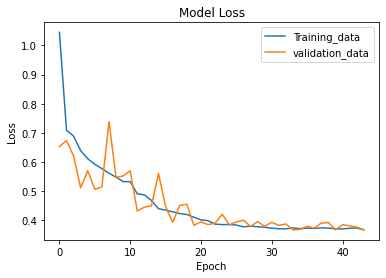

In [61]:
plot_data(history.history['loss'], history.history['val_loss'], 'Loss')

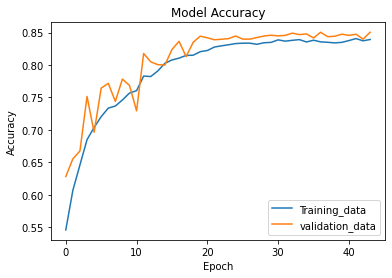

In [62]:
plot_data(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')